# Fáza 3 - Strojové učenie (v 12. týždni):
Pomer práce: Valent 50%, Pakán 50%
### 1. Jednoduchý klasifikátor na základe závislosti v dátach
### 2. Trénovanie a vyhodnotenie klasifikátorov strojového učenia
### 3. Optimalizácia alias hyperparameter tuning
### 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu
V úvode 3. fázy importujeme funkcie, ktoré budeme potrebovať k riešeniu tejto fázy.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
import itertools as it

Pomocná funkcia na overenie hľadanie a výpočet indikátora (warning) v datasete. 

In [2]:
def compare_warnings(DataFrame):
    if not DataFrame:
        return []
    else:
        indicator0 = 0
        indicator1 = 0 
        for x in DataFrame:
            if x[1] != 0:
                indicator1 += 1
            else:
                indicator0 += 1
        if indicator0 < indicator1:
            return [DataFrame[0][0], 1]
        else:
            return [DataFrame[0][0], 0]           

Funkcia na kategorizovanie záznamov v Dataframe podľa hodnoty testovanej obsahu látky v meraní. 

In [35]:
def categorize(dataframe, row):
    data = []
    data0 = []
    data1 = []
    data2 = []
    data3 = []
    data4 = []
    data5 = []
    data6 = []
    data7 = []
    data8 = []
    data9 = []
    iterrator = 0
    for key, value in dataframe.iterrows():
        print(value[row])
        if 0 <= value[row] < 0.1:
            data0.append([0, value['warning']])
            dataframe[row].array[iterrator] = 0
        elif 0.1 <= value[row] < 0.2:
            data1.append([1, value['warning']])
            dataframe[row].array[iterrator] = 1
        elif 0.2 <= value[row] < 0.3:
            data2.append([2., value['warning']])
            dataframe[row].array[iterrator] = 2
        elif 0.3 <= value[row] < 0.4:
            data3.append([3, value['warning']])
            dataframe[row].array[iterrator] = 3
        elif 0.4 <= value[row] < 0.5:
            data4.append([4, value['warning']])
            dataframe[row].array[iterrator] = 4
        elif 0.5 <= value[row] < 0.6:
            data5.append([5, value['warning']])
            dataframe[row].array[iterrator] = 5
        elif 0.6 <= value[row] < 0.7:
            data6.append([6, value['warning']])
            dataframe[row].array[iterrator] = 6
        elif 0.7 <= value[row] < 0.8:
            data7.append([7, value['warning']])
            dataframe[row].array[iterrator] = 7
        elif 0.8 <= value[row] < 0.9:
            data8.append([8, value['warning']])
            dataframe[row].array[iterrator] = 8
        elif 0.9 <= value[row] <= 1:
            data9.append([9, value['warning']])
            dataframe[row].array[iterrator] = 9
        iterrator += 1
    data.append(compare_warnings(data0))
    data.append(compare_warnings(data1))
    data.append(compare_warnings(data2))
    data.append(compare_warnings(data3))
    data.append(compare_warnings(data4))
    data.append(compare_warnings(data5))
    data.append(compare_warnings(data6))
    data.append(compare_warnings(data7))
    data.append(compare_warnings(data8))
    data.append(compare_warnings(data9))
    return data
    

Nazačiatok si naimportujeme dáta, ktoré si hneď nakopírujeme, aby sme neprepisovali originály.
Mažeme nepotrebné stĺpce. 

In [4]:
train = pd.read_csv('training_data.csv',sep="\t")
train = train.drop(columns="Unnamed: 0")
test = pd.read_csv('testing_data.csv',sep="\t")
test = test.drop(columns="Unnamed: 0")
copy_train = train.copy()
copy_test = test.copy()

Budeme aplikovať OneRule algoritmus na stĺpec s parametrom warning, takže ho môžeme vyradiť zo základu pre testovanie.

In [5]:
test_X = test.drop(columns="warning")
test_Y = test[["warning"]].copy()

Rovnaký postup použijeme aj na trénovacie dáta.

In [6]:
train_X = train.drop(columns="warning")
train_Y = train[["warning"]].copy()

Skúmame hodnoty, v ktorých sme v predošlých fázach našli vysoké korelácie a má zmysel ich ďalej skúmať.
Dáta upravíme pomocou pomocnej funkcie categorize, aby sme dostali vstup vhodný pre OneRule algoritmus.    

In [36]:
ch4=categorize(copy_train, 'CH4')
nox=categorize(copy_train, 'NOx')
pahs=categorize(copy_train,'PAHs')
pm25=categorize(copy_train, 'PM2.5')
o3=categorize(copy_train, 'O3')
copy_train.head()

2.0
6.0
4.0
2.0
6.0
5.0
7.0
9.0
4.0
9.0
3.0
7.0
2.0
6.0
4.0
5.0
9.0
7.0
6.0
2.0
6.0
9.0
5.0
3.0
3.0
5.0
6.0
4.0
6.0
7.0
7.0
4.0
9.0
3.0
4.0
6.0
5.0
7.0
6.0
0.0
7.0
0.0
5.0
7.0
8.0
0.0
4.0
7.0
5.0
7.0
9.0
6.0
5.0
7.0
9.0
0.0
9.0
4.0
6.0
6.0
4.0
7.0
6.0
5.0
7.0
0.0
4.0
6.0
0.0
9.0
3.0
5.0
2.0
2.0
6.0
0.0
6.0
6.0
4.0
0.0
4.0
5.0
2.0
5.0
4.0
5.0
4.0
0.0
5.0
9.0
3.0
7.0
6.0
0.0
4.0
7.0
6.0
9.0
7.0
3.0
9.0
6.0
3.0
9.0
6.0
3.0
3.0
7.0
0.0
5.0
0.0
9.0
8.0
9.0
2.0
9.0
7.0
5.0
7.0
6.0
2.0
7.0
4.0
0.0
5.0
3.0
8.0
4.0
4.0
5.0
7.0
6.0
3.0
9.0
6.0
6.0
8.0
3.0
9.0
5.0
4.0
8.0
6.0
7.0
7.0
0.0
5.0
5.0
4.0
6.0
0.0
5.0
9.0
9.0
9.0
8.0
5.0
7.0
4.0
8.0
9.0
7.0
4.0
9.0
2.0
8.0
3.0
9.0
8.0
5.0
4.0
2.0
4.0
4.0
2.0
9.0
7.0
4.0
0.0
0.0
7.0
2.0
7.0
7.0
2.0
0.0
3.0
9.0
9.0
5.0
7.0
5.0
6.0
3.0
3.0
7.0
4.0
8.0
3.0
8.0
4.0
0.0
7.0
0.0
6.0
4.0
9.0
0.0
3.0
5.0
7.0
9.0
7.0
4.0
6.0
0.0
6.0
5.0
9.0
6.0
9.0
9.0
8.0
8.0
4.0
5.0
8.0
4.0
8.0
9.0
5.0
9.0
4.0
5.0
4.0
6.0
0.0
0.0
6.0
9.0
6.0
7.0
2.0
6.0
0.0
9.0
9.0
6.0
3.0
6.0


,warning,PAHs,PM10,O3,NOx,CH4,PM2.5
0,0,4.0,0.880595,6.0,6.0,2.0,4.0
1,0,2.0,0.235213,5.0,6.0,6.0,5.0
2,0,7.0,0.272272,6.0,9.0,4.0,5.0
3,1,7.0,0.159343,6.0,6.0,2.0,3.0
4,1,4.0,0.406126,9.0,4.0,6.0,5.0


Vlastná implementácia One Rule algoritmu.
Pre záznamu, a pre každú hodnotu tohto záznamu vytvárame pravidlo "good_predict",
že ak záznam obsahuje "warning", tak pravidlu zvýšime hodnotu a stane sa lepším.

Funkcia v algoritme OneRule sa používa na predpovedanie nových údajov na základe pravidiel, ktoré sa model naučil počas tréningu. 

Nakoniec vypočítame presnosť počtu záznamov, kde sa nachádza warning počtom všetkých záznamov a zobrazíme presnosť (Accuracy).
na výpočet precision a recall používame funkcie z knižnice sklearn.

Funkcia recall_score a precision_score v algoritme OneRule sa používa na vyhodnotenie výkonu modelu v danom súbore údajov. Funkcia najprv použije funkciu predpovedania na generovanie predpovedí pre vstupné údaje a potom porovná predpovedané hodnoty so skutočnými hodnotami na výpočet presnosti modelu. Skóre presnosti sa potom môže použiť na vyhodnotenie výkonnosti modelu a určenie toho, ako dobre je schopný predpovedať nové údaje.
  

In [8]:
def One_rule(dataframe, data, row):
    all = 1
    sum=0
    good_predict = 0
    y_true = []
    y_pred = []
    for key, value in dataframe.iterrows():
        for x in data:
            if x[0] == value[row]:
                all += 1
                y_true.append(value['warning'])
                y_pred.append(x[1])
                if x[1] == value['warning']:
                    good_predict += 1      
    accuracy_value = round(good_predict/all,3)
    precision_value= round(precision_score(y_true, y_pred, average='binary'),3)
    recall_value = round(recall_score(y_true, y_pred, average='binary'),3)
    print("Náš 1R klasifikátor na parametri",row, "dosahuje tieto hodnoty:")
    print()
    print("\t Accuracy: " + str(accuracy_value))
    print("\t Precision: " +str(precision_value))
    print("\t Recall: " +str(recall_value))

One Rule algoritmus postupne aplikujeme na všetky premenné, ktoré chceme skúmať.

In [9]:
One_rule(copy_train, ch4, 'CH4')

Náš 1R klasifikátor na parametri CH4 dosahuje tieto hodnoty:

	 Accuracy: 0.642
	 Precision: 0.719
	 Recall: 0.655


In [10]:
One_rule(copy_train, nox, 'NOx')

Náš 1R klasifikátor na parametri NOx dosahuje tieto hodnoty:

	 Accuracy: 0.642
	 Precision: 0.777
	 Recall: 0.561


In [11]:
One_rule(copy_train, pahs, 'PAHs')

Náš 1R klasifikátor na parametri PAHs dosahuje tieto hodnoty:

	 Accuracy: 0.597
	 Precision: 0.597
	 Recall: 1.0


In [12]:
One_rule(copy_train, pm25, 'PM2.5')

Náš 1R klasifikátor na parametri PM2.5 dosahuje tieto hodnoty:

	 Accuracy: 0.597
	 Precision: 0.597
	 Recall: 1.0


In [13]:
One_rule(copy_train, o3, 'O3')

Náš 1R klasifikátor na parametri O3 dosahuje tieto hodnoty:

	 Accuracy: 0.623
	 Precision: 0.638
	 Recall: 0.851


### Decision tree
DecisionTreeClassifier je typ algoritmu učenia, ktorý možno použiť na klasifikačné úlohy podobne ako OneRule algoritmus.
Vkladáme do funkcie dáta a potom z výstupu robíme stromovú vizualizáciu.  

<function matplotlib.pyplot.show(close=None, block=None)>

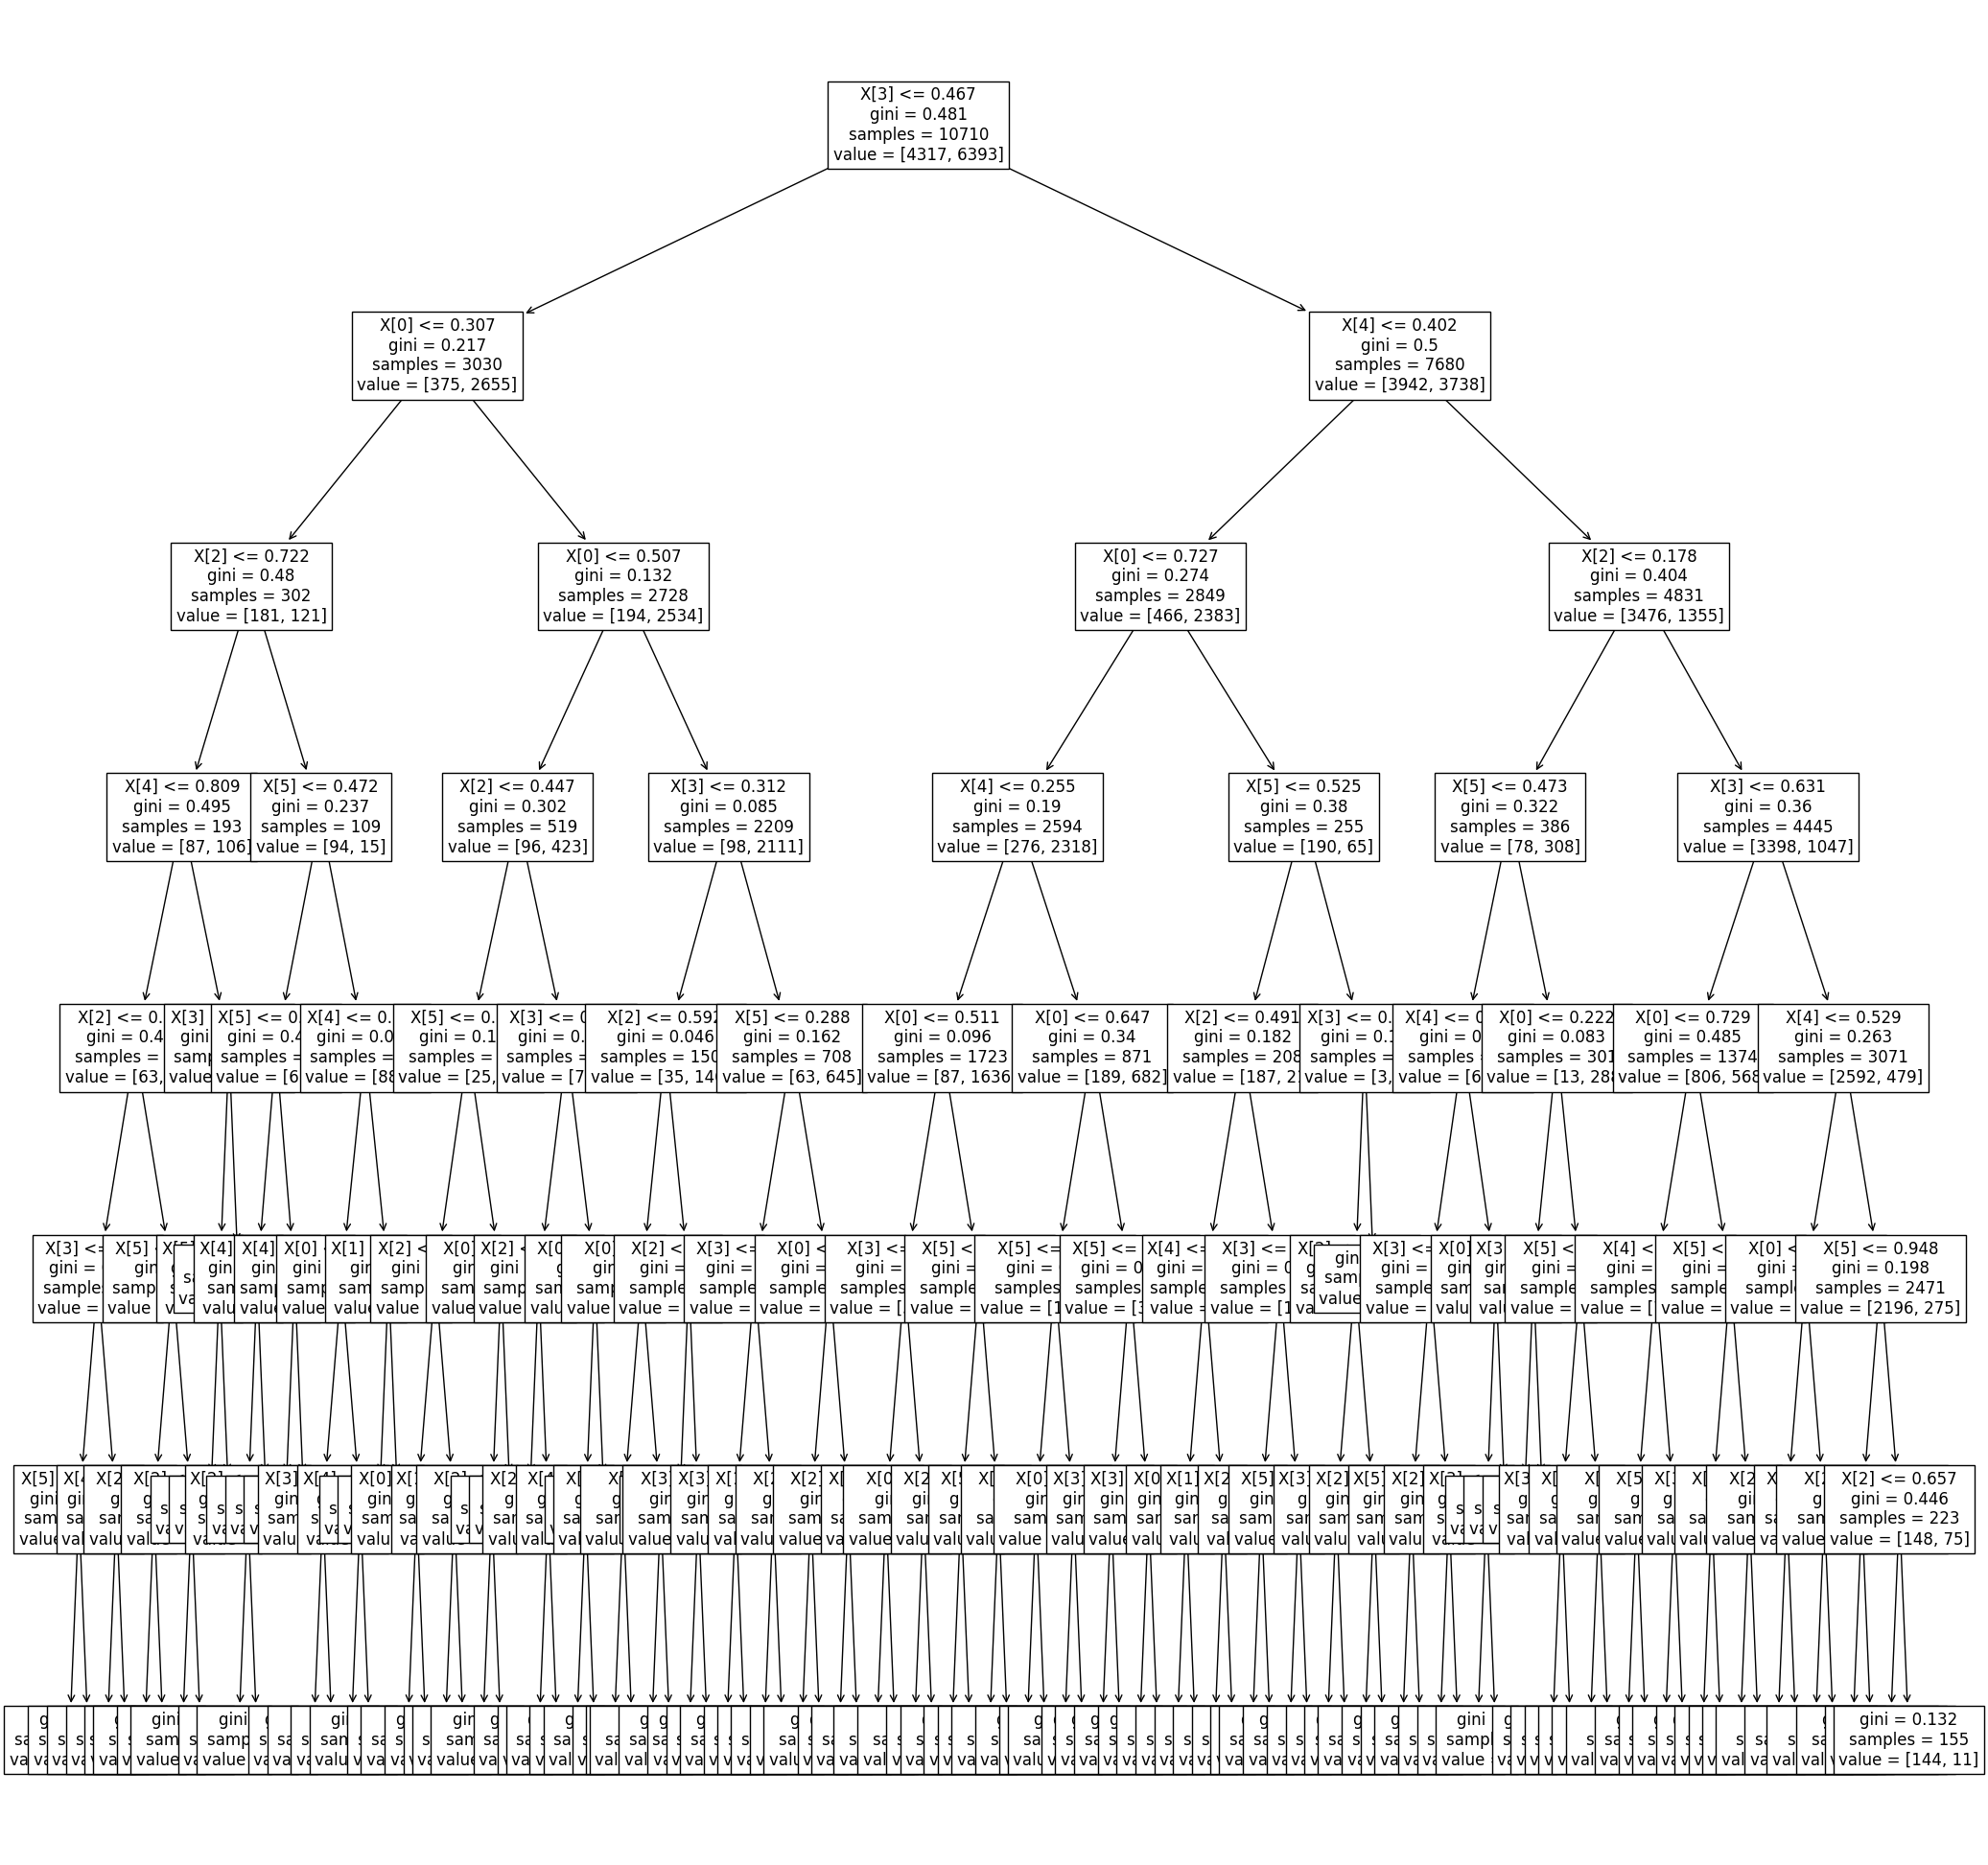

In [14]:
clf= tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(train_X, train_Y)
plt.figure(figsize=(25,25))
tree.plot_tree(clf,fontsize=12)
plt.show

Získanie hodnôt smerodajných pre vyhodnotenie klasifikátora a ich zobrazenie v reporte. 

In [38]:
predict=clf.predict(test_X)
print(classification_report(test_Y, predict,digits = 4))

              precision    recall  f1-score   support

           0     0.4156    1.0000    0.5872       495
           1     0.0000    0.0000    0.0000       696

    accuracy                         0.4156      1191
   macro avg     0.2078    0.5000    0.2936      1191
weighted avg     0.1727    0.4156    0.2440      1191



c:\Users\mattp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mattp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mattp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### Random forest

Identitický postup použijeme na otestovanie ďalšieho stromového modelu - RandomForestClassifier.

In [16]:
clf = RandomForestClassifier(max_depth=5, random_state=1)
clf.fit(train_X, train_Y['warning'])

RandomForestClassifier(max_depth=5, random_state=1)

In [17]:
predict=clf.predict(test_X)
print(classification_report(test_Y, predict,digits = 4))

              precision    recall  f1-score   support

           0     0.4156    1.0000    0.5872       495
           1     0.0000    0.0000    0.0000       696

    accuracy                         0.4156      1191
   macro avg     0.2078    0.5000    0.2936      1191
weighted avg     0.1727    0.4156    0.2440      1191



c:\Users\mattp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mattp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mattp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Zadanie parametrov, podľa ktorých hodnoty riadia proces učenia a určujú hodnoty parametrov modelu, ktoré sa nakoniec algoritmus učí, za účelom optimalizácie.

In [18]:
hyperparameters={
   'max_depth' : [10, 15, 20, 25],
   'min_samples_split' : [2, 3, 4, 5],
   'min_samples_leaf' :[1,2,3,5,8,13,21,34,55],
   'max_features' :[1,2,3,4],
    'criterion' : ['gini', 'entropy'],
   'splitter' : ['best', 'random']
}

Aplikovanie hyperparametrov do stromu DecisionTreeClassifier

In [19]:
dtree = tree.DecisionTreeClassifier()
grid = GridSearchCV(dtree, hyperparameters, cv=5, verbose=1, n_jobs=-1)
top_res = grid.fit(train_X, train_Y)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


In [20]:
print(top_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [1, 2, 3, 5, 8, 13, 21, 34, 55],
                         'min_samples_split': [2, 3, 4, 5],
                         'splitter': ['best', 'random']},
             verbose=1)


Výpis výsledkov

In [21]:
predict = top_res.predict(test_X)
acc=(accuracy_score(test_Y, predict))
prec=(precision_score(test_Y, predict))
rec=(recall_score(test_Y, predict))
print("Accuracy: " + str(acc))
print("Precision: " +str(prec))
print("Recall: " +str(rec))

Accuracy: 0.5843828715365239
Precision: 0.5843828715365239
Recall: 1.0


In [22]:
print("Najlepšie dosiahnuté skóre bolo nasledovné:", grid.best_score_)
grid.best_params_

Najlepšie dosiahnuté skóre bolo nasledovné: 0.884967320261438


{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 4,
 'min_samples_leaf': 8,
 'min_samples_split': 4,
 'splitter': 'best'}

In [23]:
best = grid.best_estimator_
best
#plot = plt.figure(figsize=(50,50))
#_ = tree.plot_tree(best, feature_names=train_X.columns, class_names=['0', '1'])
#plt.savefig('Hyper.png')
#plt.show

DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=4,
                       min_samples_leaf=8, min_samples_split=4)

Pomocné funkcie na úpravu datasetov za účelom pridania kvantilou.

In [24]:
def transform_col(dataframe, column):
        quartil_down = dataframe[column].quantile(0.05)
        quartil_up = dataframe[column].quantile(0.95)
        
        for i, value in dataframe.iterrows():
            if value[column] < quartil_down:
                dataframe.loc[i, column] = quartil_down
            elif value[column] > quartil_up:
                dataframe.loc[i, column] = quartil_up
        return dataframe
def transform(dataframe):
    col_names= list(dataframe.columns.values)
    for column_name in col_names:
        transform_col(dataframe,column_name)
    return dataframe

Pomocná funkcia na identifikáciiu hľadaných "dobrých stĺpcov" pomocou LogisticRegression z knižnice sklearn

In [25]:
def identify_good_cols(training_data):
    good_cols = ['warning']
    test_out = training_data["warning"]
    test_input = training_data.copy()
    test_input.drop("warning", axis=1, inplace=True)
    sfm = SelectFromModel(LogisticRegression(), threshold=0.3)
    sfm.fit(test_input, test_out)
    for feature_list_index in sfm.get_support(indices=True):
        good_cols.append(test_input.columns[feature_list_index])
    return good_cols

Vytvorenie Pipeline podľa zadaných parametrov - typ hľadania korelácií a nastavenie outlierov, typ transformátora a typ scalera.
Všetky funkcie, ktoré sme robili v predošlých fázach pokope.   

In [26]:
def transform_data(nas,outliers,transformer,scaler):
    stations= pd.read_csv("data/stations.csv", sep="\t")
    measurements= pd.read_csv("data/measurements.csv", sep="\t")
    stations.drop(columns=["QoS"], inplace=True)
    stations.drop(columns=["revision"], inplace=True)
    stations.drop(columns=["code"], inplace=True)
    stations.drop(columns=["station"], inplace=True)
    data = pd.merge(measurements, stations, on = ["latitude"], how = "left")
    data.drop(columns=["longitude_x"], inplace=True)
    data.rename(columns={'longitude_y': 'longitude'}, inplace=True) 
    data = data.drop_duplicates()
    if nas == "drop":
        data.dropna(inplace=True)
    elif nas == "median":
        data.fillna(data.median(), inplace=True)
    elif nas == "average":
        data.fillna(data.mean(), inplace=True)
    elif nas == "knn":
        imputer = KNNImputer(n_neighbors=3)
        data = imputer.fit_transform(data)
    else:
        pass
    if outliers == "quantile":
        transform(data)
    elif outliers == "drop":
        z_scores = stats.zscore(data) 
        abs_z_scores = np.abs(z_scores)
        filtered_entries = (abs_z_scores <= 3).all(axis=1)
        data = data[filtered_entries]
    else: 
        pass
    if transformer == "yes":
        pipeline = Pipeline([('power', PowerTransformer(method='yeo-johnson'))])
        new = pipeline.fit_transform(data)
    if scaler == "yes":
        pipeline_scale = Pipeline([('minmax', MinMaxScaler())])
        new = pipeline_scale.fit_transform(data)
    if transformer == "no" and scaler == "no":
        new = data
    new=pd.DataFrame(new)
    new.columns = data.columns.copy()
    training_data, test_data = train_test_split(new, test_size=0.1, random_state=42)
    x = identify_good_cols(training_data)
    training_data = training_data[x]
    training_data["warning"]=training_data["warning"].astype(int)
    test_data = test_data[x]
    test_data["warning"]=test_data["warning"].astype(int)
    return training_data,test_data

Vygenerovanie reportu so vstupmi zo stromových klasifikátorov. 

In [27]:
def stromceky(strom,train,test):
    test_X = test.drop(columns="warning")
    test_Y = test[["warning"]].copy()
    train_X = train.drop(columns="warning")
    train_Y = train[["warning"]].copy()
    if strom == "forest":   
        clf = RandomForestClassifier(max_depth=5, random_state=1)
        clf.fit(train_X, train_Y['warning'])
        predict=clf.predict(test_X)
        return classification_report(test_Y, predict,digits = 4)
    elif strom == "tree":
        clf= tree.DecisionTreeClassifier(max_depth=7)
        clf = clf.fit(train_X, train_Y)
        predict=clf.predict(test_X)
        return classification_report(test_Y, predict,digits = 4)

In [32]:
options={
    'nas' : ["drop","median","average","knn"],
    'outliers': ["quantile","drop"],
    'transformer': ["yes","no"],
    'scaler' : ["yes","no"],
    'strom' : ["forest","tree"]
}
allNames = sorted(options)
combinations = it.product(*(options[Name] for Name in allNames))
for x in combinations:
    print(x)
    train,test = transform_data(x[0],x[1],x[2],x[3])
    print(x)
    answer = stromceky(x[4],train,test)
    print(answer)

('drop', 'quantile', 'yes', 'forest', 'yes')


ValueError: Unknown label type: 'continuous'